<a href="https://colab.research.google.com/github/jsokolowska/siema-my-z-mechatro/blob/main/wersja_%C5%82adna.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Setup
=====


In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mutual_info_score
from sklearn.preprocessing import LabelEncoder
from scipy.stats import spearmanr
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
import plotly.express as px

In [15]:
data_path = "/content/drive/MyDrive/Data/hackathon/final_train.csv"

df = pd.read_csv(data_path, index_col=0)
df.head()

,Activity,"angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyAccMean,gravity)","angle(tBodyGyroJerkMean,gravityMean)","angle(tBodyGyroMean,gravityMean)",energy-mean(),"fBodyAcc-bandsEnergy()-1,16","fBodyAcc-bandsEnergy()-1,16.1","fBodyAcc-bandsEnergy()-1,16.2","fBodyAcc-bandsEnergy()-1,24","fBodyAcc-bandsEnergy()-1,24.1","fBodyAcc-bandsEnergy()-1,24.2","fBodyAcc-bandsEnergy()-1,8","fBodyAcc-bandsEnergy()-1,8.1","fBodyAcc-bandsEnergy()-1,8.2","fBodyAcc-bandsEnergy()-17,24","fBodyAcc-bandsEnergy()-17,24.1","fBodyAcc-bandsEnergy()-17,24.2","fBodyAcc-bandsEnergy()-17,32","fBodyAcc-bandsEnergy()-17,32.1","fBodyAcc-bandsEnergy()-17,32.2","fBodyAcc-bandsEnergy()-25,32","fBodyAcc-bandsEnergy()-25,32.1","fBodyAcc-bandsEnergy()-25,32.2","fBodyAcc-bandsEnergy()-25,48","fBodyAcc-bandsEnergy()-25,48.1","fBodyAcc-bandsEnergy()-25,48.2","fBodyAcc-bandsEnergy()-33,40","fBodyAcc-bandsEnergy()-33,40.1","fBodyAcc-bandsEnergy()-33,40.2","fBodyAcc-bandsEnergy()-33,48","fBodyAcc-bandsEnergy()-33,48.1","fBodyAcc-bandsEnergy()-33,48.2","fBodyAcc-bandsEnergy()-41,48","fBodyAcc-bandsEnergy()-41,48.1","fBodyAcc-bandsEnergy()-41,48.2","fBodyAcc-bandsEnergy()-49,56",...,"tGravityAcc-correlation()-Y,Z",tGravityAcc-energy()-X,tGravityAcc-energy()-Y,tGravityAcc-energy()-Z,tGravityAcc-entropy()-X,tGravityAcc-entropy()-Y,tGravityAcc-entropy()-Z,tGravityAcc-iqr()-X,tGravityAcc-iqr()-Y,tGravityAcc-iqr()-Z,tGravityAcc-mad()-X,tGravityAcc-mad()-Y,tGravityAcc-mad()-Z,tGravityAcc-max()-X,tGravityAcc-max()-Y,tGravityAcc-max()-Z,tGravityAcc-mean()-X,tGravityAcc-mean()-Y,tGravityAcc-mean()-Z,tGravityAcc-min()-X,tGravityAcc-min()-Y,tGravityAcc-min()-Z,tGravityAcc-sma(),tGravityAcc-std()-X,tGravityAcc-std()-Y,tGravityAcc-std()-Z,tGravityAccMag-arCoeff()1,tGravityAccMag-arCoeff()2,tGravityAccMag-arCoeff()3,tGravityAccMag-arCoeff()4,tGravityAccMag-energy(),tGravityAccMag-entropy(),tGravityAccMag-iqr(),tGravityAccMag-mad(),tGravityAccMag-max(),tGravityAccMag-mean(),tGravityAccMag-min(),tGravityAccMag-sma(),tGravityAccMag-std(),void()
0,STANDING,-1.574191,-0.805700,-2.453831,-1.861714,0.115517,-2.023369,3.125860,-9.474436,3.622600,6.137246,2.503062,5.776680,3.242765,-1.352936,-1.537732,2.828395,8.603183,-2.228620,5.355308,3.987723,1.880228,1.384042,-2.163548,0.483175,2.942713,5.837147,2.957527,-1.770934,-5.580564,13.725027,1.724643,-0.519345,4.233416,0.953127,0.807692,2.624547,-3.005993,3.329588,2.866778,...,2.988204,1.531084,-3.422785,1.852121,8.394366,3.246233,0.937300,4.725389,-1.578871,-0.442374,4.068593,4.705346,7.195449,-6.003664,0.607255,-1.499318,2.246320,2.861260,3.815614,-2.151051,-3.122438,-0.336110,6.357369,3.741996,1.394575,4.017211,2.481302,5.774536,1.754626,1.180533,5.049130,3.272281,5.103018,-0.823302,3.063681,-0.928676,-1.007695,3.094236,1.669987,1.0
1,WALKING_UPSTAIRS,-1.568669,-0.612620,-2.488338,-1.751117,0.218134,0.280294,7.953403,-0.679894,2.512880,5.740178,2.803435,5.484726,2.102368,-1.355854,-1.416568,2.527046,8.046001,-1.986672,5.284168,3.598328,1.892567,1.417711,-2.027475,0.436458,2.908602,5.819734,2.551773,-1.756530,-5.503246,13.251491,1.714753,-0.552312,3.566532,0.922455,0.726768,2.081277,-3.081267,3.140684,2.684137,...,2.859864,1.585023,-3.387872,1.698743,8.112279,1.926083,2.348895,4.719540,-1.521161,-0.463599,4.063648,4.730261,7.221653,-5.789276,0.417687,-0.703212,2.488702,2.391994,5.884982,-2.187197,-3.306482,-0.814718,6.077734,3.720622,1.202847,4.050714,4.539801,4.618405,1.727481,0.220730,4.565443,4.440779,3.288399,-2.689605,1.705341,-0.822617,-0.572410,-2.187890,-0.544652,2.0
2,LAYING,-1.548333,-0.139628,-2.380889,-1.915239,0.067613,-0.887342,6.007361,-11.906904,3.621984,6.158630,2.495276,5.776843,3.314383,-1.352860,-1.537483,2.845718,8.618923,-2.232214,5.378175,3.998898,1.879989,1.372814,-2.169002,0.485317,2.957325,5.841023,2.974139,-1.775050,-5.600164,13.743085,1.726239,-0.505341,4.256780,0.957134,0.831419,2.640759,-2.999393,3.359696,2.868557,...,3.717038,1.851578,-4.07074

In [16]:
X = df.drop("Activity", axis=1)
y = df["Activity"]

Analiza danych 
===


In [17]:
print(df.shape)
#col = df.columns.to_list()
#col

(11086, 572)


Znaczenie kolumn na pierwszy rzut oka nie jest jasne, jednak chwila przeszukiwania internetu i można znaleźć dobre wyjaśnienie tych danych np. https://github.com/KarthikMurugadoss1804/Human-Activity-Recognition.

Jednak pewne atrybuty od początku wzbudzają wątpliwości, np. atrybut void() wydaje się być zupełnie przypadkowo dodany. Pozostałe atrybuty wydają sie sensownie dobrane. 

Można też zauważyć pewną powtarzalność - są "sparowane" atrybuty zaczynające się od t lub od f, które zgodnie z podlinkowanych artykułek powstały po zastosowaniu transformaty fouriera dla atrybutów zaczynających się od "t". To potencjalna redundacja, którą prawdopodobnie można bezstratnie usunąć. 

In [18]:
df["Activity"].unique()

array(['STANDING', 'WALKING_UPSTAIRS', 'LAYING', 'WALKING', 'SITTING',
       'WALKING_DOWNSTAIRS'], dtype=object)

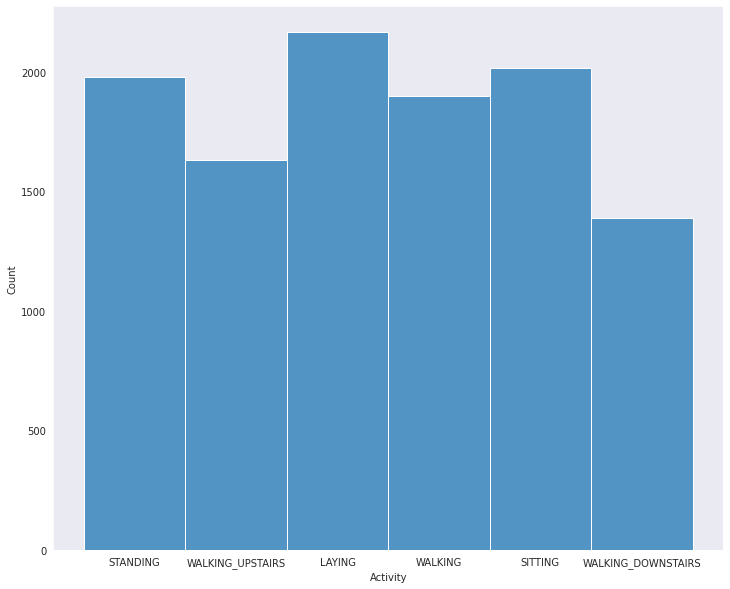

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(12,10))
sns.set_style("dark")
sns.histplot(df["Activity"], edgecolor='white')

Klasy są w miare równomniernie rozłożone, więc nie powinny powodować problemów podczas klasyfikacji. 

In [20]:
# sprawdzenie jak wiele wartości jest pustych
df.isnull().sum()

Activity                                 0
angle(X,gravityMean)                    57
angle(Y,gravityMean)                    68
angle(Z,gravityMean)                    60
angle(tBodyAccJerkMean),gravityMean)    52
                                        ..
tGravityAccMag-mean()                   65
tGravityAccMag-min()                    66
tGravityAccMag-sma()                    57
tGravityAccMag-std()                    46
void()                                  65
Length: 572, dtype: int64

In [21]:
# filling empty spaces with mean
df = df.fillna(df.mean())
df.isnull().sum() # sanity check

Activity                                0
angle(X,gravityMean)                    0
angle(Y,gravityMean)                    0
angle(Z,gravityMean)                    0
angle(tBodyAccJerkMean),gravityMean)    0
                                       ..
tGravityAccMag-mean()                   0
tGravityAccMag-min()                    0
tGravityAccMag-sma()                    0
tGravityAccMag-std()                    0
void()                                  0
Length: 572, dtype: int64

In [22]:
df.head()

,Activity,"angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyAccMean,gravity)","angle(tBodyGyroJerkMean,gravityMean)","angle(tBodyGyroMean,gravityMean)",energy-mean(),"fBodyAcc-bandsEnergy()-1,16","fBodyAcc-bandsEnergy()-1,16.1","fBodyAcc-bandsEnergy()-1,16.2","fBodyAcc-bandsEnergy()-1,24","fBodyAcc-bandsEnergy()-1,24.1","fBodyAcc-bandsEnergy()-1,24.2","fBodyAcc-bandsEnergy()-1,8","fBodyAcc-bandsEnergy()-1,8.1","fBodyAcc-bandsEnergy()-1,8.2","fBodyAcc-bandsEnergy()-17,24","fBodyAcc-bandsEnergy()-17,24.1","fBodyAcc-bandsEnergy()-17,24.2","fBodyAcc-bandsEnergy()-17,32","fBodyAcc-bandsEnergy()-17,32.1","fBodyAcc-bandsEnergy()-17,32.2","fBodyAcc-bandsEnergy()-25,32","fBodyAcc-bandsEnergy()-25,32.1","fBodyAcc-bandsEnergy()-25,32.2","fBodyAcc-bandsEnergy()-25,48","fBodyAcc-bandsEnergy()-25,48.1","fBodyAcc-bandsEnergy()-25,48.2","fBodyAcc-bandsEnergy()-33,40","fBodyAcc-bandsEnergy()-33,40.1","fBodyAcc-bandsEnergy()-33,40.2","fBodyAcc-bandsEnergy()-33,48","fBodyAcc-bandsEnergy()-33,48.1","fBodyAcc-bandsEnergy()-33,48.2","fBodyAcc-bandsEnergy()-41,48","fBodyAcc-bandsEnergy()-41,48.1","fBodyAcc-bandsEnergy()-41,48.2","fBodyAcc-bandsEnergy()-49,56",...,"tGravityAcc-correlation()-Y,Z",tGravityAcc-energy()-X,tGravityAcc-energy()-Y,tGravityAcc-energy()-Z,tGravityAcc-entropy()-X,tGravityAcc-entropy()-Y,tGravityAcc-entropy()-Z,tGravityAcc-iqr()-X,tGravityAcc-iqr()-Y,tGravityAcc-iqr()-Z,tGravityAcc-mad()-X,tGravityAcc-mad()-Y,tGravityAcc-mad()-Z,tGravityAcc-max()-X,tGravityAcc-max()-Y,tGravityAcc-max()-Z,tGravityAcc-mean()-X,tGravityAcc-mean()-Y,tGravityAcc-mean()-Z,tGravityAcc-min()-X,tGravityAcc-min()-Y,tGravityAcc-min()-Z,tGravityAcc-sma(),tGravityAcc-std()-X,tGravityAcc-std()-Y,tGravityAcc-std()-Z,tGravityAccMag-arCoeff()1,tGravityAccMag-arCoeff()2,tGravityAccMag-arCoeff()3,tGravityAccMag-arCoeff()4,tGravityAccMag-energy(),tGravityAccMag-entropy(),tGravityAccMag-iqr(),tGravityAccMag-mad(),tGravityAccMag-max(),tGravityAccMag-mean(),tGravityAccMag-min(),tGravityAccMag-sma(),tGravityAccMag-std(),void()
0,STANDING,-1.574191,-0.805700,-2.453831,-1.861714,0.115517,-2.023369,3.125860,-9.474436,3.622600,6.137246,2.503062,5.776680,3.242765,-1.352936,-1.537732,2.828395,8.603183,-2.228620,5.355308,3.987723,1.880228,1.384042,-2.163548,0.483175,2.942713,5.837147,2.957527,-1.770934,-5.580564,13.725027,1.724643,-0.519345,4.233416,0.953127,0.807692,2.624547,-3.005993,3.329588,2.866778,...,2.988204,1.531084,-3.422785,1.852121,8.394366,3.246233,0.937300,4.725389,-1.578871,-0.442374,4.068593,4.705346,7.195449,-6.003664,0.607255,-1.499318,2.246320,2.861260,3.815614,-2.151051,-3.122438,-0.336110,6.357369,3.741996,1.394575,4.017211,2.481302,5.774536,1.754626,1.180533,5.049130,3.272281,5.103018,-0.823302,3.063681,-0.928676,-1.007695,3.094236,1.669987,1.0
1,WALKING_UPSTAIRS,-1.568669,-0.612620,-2.488338,-1.751117,0.218134,0.280294,7.953403,-0.679894,2.512880,5.740178,2.803435,5.484726,2.102368,-1.355854,-1.416568,2.527046,8.046001,-1.986672,5.284168,3.598328,1.892567,1.417711,-2.027475,0.436458,2.908602,5.819734,2.551773,-1.756530,-5.503246,13.251491,1.714753,-0.552312,3.566532,0.922455,0.726768,2.081277,-3.081267,3.140684,2.684137,...,2.859864,1.585023,-3.387872,1.698743,8.112279,1.926083,2.348895,4.719540,-1.521161,-0.463599,4.063648,4.730261,7.221653,-5.789276,0.417687,-0.703212,2.488702,2.391994,5.884982,-2.187197,-3.306482,-0.814718,6.077734,3.720622,1.202847,4.050714,4.539801,4.618405,1.727481,0.220730,4.565443,4.440779,3.288399,-2.689605,1.705341,-0.822617,-0.572410,-2.187890,-0.544652,2.0
2,LAYING,-1.548333,-0.139628,-2.380889,-1.915239,0.067613,-0.887342,6.007361,-11.906904,3.621984,6.158630,2.495276,5.776843,3.314383,-1.352860,-1.537483,2.845718,8.618923,-2.232214,5.378175,3.998898,1.879989,1.372814,-2.169002,0.485317,2.957325,5.841023,2.974139,-1.775050,-5.600164,13.743085,1.726239,-0.505341,4.256780,0.957134,0.831419,2.640759,-2.999393,3.359696,2.868557,...,3.717038,1.851578,-4.07074

Redukcja wymiarowości 
=====
Redukcja wymiarowości poprzez selekcję atrybutów

In [23]:
# sprawdzenie korelacji atrybutów z atrybutem klasyfikacji
res = []
df_no_a = df.drop("Activity", axis=1)
labels = df["Activity"]

for f in df_no_a.columns:
  res.append(df[f].corr(labels, method='spearman'))

In [24]:
col = df_no_a .columns.to_list()

correl = pd.DataFrame(res, index = col)
weak_f = correl[abs(correl[0]) < 0.3]

weak_f.index 

Index(['angle(tBodyAccMean,gravity)', 'angle(tBodyGyroJerkMean,gravityMean)',
       'angle(tBodyGyroMean,gravityMean)', 'energy-mean()',
       'fBodyAcc-kurtosis()-X', 'fBodyAcc-kurtosis()-Y',
       'fBodyAcc-kurtosis()-Z', 'fBodyAcc-main()-X', 'fBodyAcc-main()-Z',
       'fBodyAcc-maxInds-Y',
       ...
       'tGravityAcc-entropy()-Y', 'tGravityAcc-entropy()-Z',
       'tGravityAcc-iqr()-X', 'tGravityAcc-mad()-X', 'tGravityAcc-sma()',
       'tGravityAcc-std()-X', 'tGravityAccMag-arCoeff()4',
       'tGravityAccMag-mad()', 'tGravityAccMag-sma()', 'void()'],
      dtype='object', length=106)

Mamy w danych sporo atrybutów o niskiej korelacji z atrybutem klasyfikacji - prawdopodobnie bez wielkich strat dla dokładności modelu można je usunąć. Wśród nich jest też atrybut wcześniej wyróżniony jako podejrzany - "void()".


In [25]:
# sprawdzenie korelacji odpowiadających sobie atrybutów f i t - podejrzewamy, że mogą wprowadzać redundancję
def inv_fourier(df, fourier_labels):
  inv_fourier_labels = [label.replace('f', 't', 1) for label in fourier_labels]
  return df.filter(items=inv_fourier_labels)

def fourier_correlation(df, inv_fourier_labels):
  results = pd.DataFrame(columns=['label', 'value'])
  for label in inv_fourier_labels:
    new_row = {'label': label[1:], 'value': df[label].corr(df[label.replace('t', 'f', 1)])}
    results = results.append(new_row, ignore_index=True)
  return results

fourier_labels = df.filter(regex='^f').columns
inv_fourier_labels = inv_fourier(df, fourier_labels)

correlation = fourier_correlation(df, inv_fourier_labels)

def filter_correlating_fourier(df, correlation, threshold=0.5):
  filtered = df.copy()
  for index, row in correlation.iterrows():
    if abs(float(row['value']) > 0.5):
      filtered = filtered.drop(columns=['f'+row['label']], errors='ignore')

  return filtered



no_fourier = filter_correlating_fourier(df, correlation)
print(no_fourier.shape, df.shape) # usunięto 50 atrybutów



(11086, 524) (11086, 572)


In [26]:
# normalizacja
import sklearn.preprocessing as preprocessing
X = df.drop('Activity', axis='columns')
X = X.fillna(X.mean())

def normalize(df):
    cols = df.columns
    x = df.values #returns a numpy array
    min_max_scaler = preprocessing.StandardScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    return pd.DataFrame(x_scaled, columns=cols)

X = normalize(X)

In [27]:
# przykładowa klasyfikacja z wykorzystaniem wszystkich atrybutów
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

y = labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=69)

model_lr = LogisticRegression(random_state=69).fit(X_train, y_train)
best_score = model_lr.score(X_test, y_test)
best_score

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



0.9822609741431149

In [28]:
# zbiór atrybutów zredukowany o te nisko skorelowane z atrybutem docelowym
weak_f = correl[abs(correl[0]) < 0.5]

X_train_reduced = X_train.drop(weak_f.index, axis=1)
print(X_train.shape, X_train_reduced.shape, weak_f.shape) #sanity check

X_test_reduced = X_test.drop(weak_f.index, axis=1)
print(X_test.shape, X_test_reduced.shape, weak_f.shape) #sanity check


X_train_reduced.head()

(7760, 571) (7760, 418) (153, 1)
(3326, 571) (3326, 418) (153, 1)


,"angle(Y,gravityMean)","angle(Z,gravityMean)","fBodyAcc-bandsEnergy()-1,16","fBodyAcc-bandsEnergy()-1,16.1","fBodyAcc-bandsEnergy()-1,16.2","fBodyAcc-bandsEnergy()-1,24","fBodyAcc-bandsEnergy()-1,24.1","fBodyAcc-bandsEnergy()-1,24.2","fBodyAcc-bandsEnergy()-1,8","fBodyAcc-bandsEnergy()-1,8.1","fBodyAcc-bandsEnergy()-1,8.2","fBodyAcc-bandsEnergy()-17,24","fBodyAcc-bandsEnergy()-17,24.1","fBodyAcc-bandsEnergy()-17,24.2","fBodyAcc-bandsEnergy()-17,32","fBodyAcc-bandsEnergy()-17,32.1","fBodyAcc-bandsEnergy()-17,32.2","fBodyAcc-bandsEnergy()-25,32","fBodyAcc-bandsEnergy()-25,32.1","fBodyAcc-bandsEnergy()-25,32.2","fBodyAcc-bandsEnergy()-25,48","fBodyAcc-bandsEnergy()-25,48.1","fBodyAcc-bandsEnergy()-25,48.2","fBodyAcc-bandsEnergy()-33,40","fBodyAcc-bandsEnergy()-33,40.1","fBodyAcc-bandsEnergy()-33,40.2","fBodyAcc-bandsEnergy()-33,48","fBodyAcc-bandsEnergy()-33,48.1","fBodyAcc-bandsEnergy()-33,48.2","fBodyAcc-bandsEnergy()-41,48","fBodyAcc-bandsEnergy()-41,48.1","fBodyAcc-bandsEnergy()-41,48.2","fBodyAcc-bandsEnergy()-49,56","fBodyAcc-bandsEnergy()-49,56.1","fBodyAcc-bandsEnergy()-49,56.2","fBodyAcc-bandsEnergy()-49,64","fBodyAcc-bandsEnergy()-49,64.1","fBodyAcc-bandsEnergy()-49,64.2","fBodyAcc-bandsEnergy()-57,64","fBodyAcc-bandsEnergy()-57,64.1",...,tBodyGyroJerk-std()-Z,tBodyGyroJerkMag-energy(),tBodyGyroJerkMag-entropy(),tBodyGyroJerkMag-iqr(),tBodyGyroJerkMag-mad(),tBodyGyroJerkMag-max(),tBodyGyroJerkMag-mean(),tBodyGyroJerkMag-min(),tBodyGyroJerkMag-sma(),tBodyGyroJerkMag-std(),tBodyGyroMag-energy(),tBodyGyroMag-iqr(),tBodyGyroMag-mad(),tBodyGyroMag-max(),tBodyGyroMag-mean(),tBodyGyroMag-min(),tBodyGyroMag-sma(),tBodyGyroMag-std(),tGravityAcc-energy()-Y,tGravityAcc-iqr()-Y,tGravityAcc-iqr()-Z,tGravityAcc-mad()-Y,tGravityAcc-mad()-Z,tGravityAcc-max()-Y,tGravityAcc-max()-Z,tGravityAcc-mean()-Y,tGravityAcc-mean()-Z,tGravityAcc-min()-Y,tGravityAcc-min()-Z,tGravityAcc-std()-Y,tGravityAcc-std()-Z,tGravityAccMag-arCoeff()1,tGravityAccMag-arCoeff()2,tGravityAccMag-energy(),tGravityAccMag-entropy(),tGravityAccMag-iqr(),tGravityAccMag-max(),tGravityAccMag-mean(),tGravityAccMag-min(),tGravityAccMag-std()
9302,0.009843,-1.257162,-0.537703,-0.341473,1.576705,-0.561890,-0.274796,-1.525437,0.075957,-0.562914,-1.741297,0.709923,0.261648,-0.652598,0.644501,-0.283918,0.478868,-0.302999,0.330492,0.158987,-0.471353,-0.320008,-0.095018,-0.747420,0.253338,9.264982e-03,-0.741679,0.257189,-0.059444,-6.709635e-01,0.235534,-0.194014,-1.366710,-0.310628,0.578006,-1.575181,2.406789e-01,-0.358124,-1.784856,0.079036,...,0.498780,-0.179661,-1.044837,-0.676940,-0.560106,-0.749524,-0.675108,-0.949678,-0.675570,0.604991,-1.455742,0.795221,-1.038952,-1.401031,-1.453829,0.476727,1.453189,-1.143953,0.611093,0.959735,-0.139256,0.832211,-0.114803,-0.106018,1.347740,-0.059840,1.337926,-0.020970,-1.317076,-0.789835,-0.060966,0.598796,-0.728873,-0.702212,1.049211,-0.841848,-0.896061,0.969655,0.913064,-0.871935
9712,-0.824920,-0.693435,-2.432412,-2.050226,0.088009,-2.359255,-2.229255,-0.129832,2.715551,-1.776965,-0.022966,0.565213,-2.987940,-0.360762,0.851807,2.661683,0.413676,-1.745526,-0.749502,-0.500402,-2.316969,1.481496,0.702941,-2.767155,-1.487777,-7.121111e-15,-3.151245,-2.886143,-1.104728,1.074969e-13,-4.966180,-1.947234,-3.316055,2.566939,0.273146,-3.867054,8.542493e-14,-0.118011,-4.449384,0.311201,...,2.107211,-1.982993,-1.096910,-2.022512,-2.150507,-2.135333,-1.871971,-2.053274,-1.872635,2.083779,-1.564614,1.060964,-1.169419,-1.543027,-1.504337,2.283441,1.503688,-1.238497,0.326601,-0.361583,-2.147677,-0.173559,-1.751765,0.876742,0.668304,0.869099,0.728713,0.871439,-0.780410,0.099483,-1.610931,0.691734,-0.366620,-2.115048,1.156361,-1.493479,-1.868273,1.673292,0.668211,-1.879839
103,0.757762,0.520024,0.687608,0.729314,-0.717245,0.699195,0.731908,0.727979,-0.635311,0.730251,0.693911,-0.666333,0.594163,0.569945,-0.671908,-0.602208,-0.565275,0.572158,0.526752,0.449649,0.618609,-0.559495,-0.473605,0.630075,0.534426,4.484797e-01,0.636675,0.560888,0.487948,5.977030

In [29]:
model_lr = LogisticRegression(random_state=69).fit(X_train_reduced, y_train)
model_lr.score(X_test_reduced, y_test) # 0.969 czyli lekki, ale akceptowalny spadek

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



0.9705351773902585

In [30]:
# dodatkowa redukcja wewnętrznie skorelowaych atrybutów fouriera
X_train_reduced = filter_correlating_fourier(X_train_reduced, correlation)
print(X_train.shape, X_train_reduced.shape) #sanity check

X_test_reduced = filter_correlating_fourier(X_test_reduced,correlation )
print(X_test.shape, X_test_reduced.shape) #sanity check

model_lr = LogisticRegression(random_state=69).fit(X_train_reduced, y_train)
model_lr.score(X_test_reduced, y_test) #0.966 czyli mały, zupełnie okej spadek

(7760, 571) (7760, 370)
(3326, 571) (3326, 370)


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



0.9687312086590499

Strojenie hiperparametrów redukcji atrybutów
====


In [31]:
#strojenie hiperparametru progu usuwania atrybutów małoinformatywnych
thresholds = [0.3, 0.4, 0.5, 0.6, 0.7]
res = []
num = []

for th in thresholds:

  weak_f = correl[abs(correl[0]) < th]
  num.append(len(weak_f.index ))

  # dropping according to threshold
  X_train_reduced = X_train.drop(weak_f.index, axis=1)
  X_test_reduced = X_test.drop(weak_f.index, axis=1)

  #dropping correlated fourier attibutes
  X_test_reduced = filter_correlating_fourier(X_test_reduced, correlation)
  X_train_reduced = filter_correlating_fourier(X_train_reduced, correlation)

  model_lr = LogisticRegression(random_state=69).fit(X_train_reduced, y_train)
  score = model_lr.score(X_test_reduced, y_test)
  print("----------------------", th)
  res.append(score)


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



---------------------- 0.3


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



---------------------- 0.4


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



---------------------- 0.5


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



---------------------- 0.6
---------------------- 0.7


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



In [32]:
for i in range (len(res)):
  print(f'Score for threshold {thresholds[i]} - {res[i]}, dropeed {num[i]} features. Difference to best score: {best_score- res[i]}')

Score for threshold 0.3 - 0.9804570054119062, dropeed 106 features. Difference to best score: 0.0018039687312086938
Score for threshold 0.4 - 0.9768490679494889, dropeed 139 features. Difference to best score: 0.0054119061936259705
Score for threshold 0.5 - 0.9687312086590499, dropeed 153 features. Difference to best score: 0.013529765484064926
Score for threshold 0.6 - 0.9236319903788335, dropeed 176 features. Difference to best score: 0.058628983764281384
Score for threshold 0.7 - 0.9116055321707757, dropeed 301 features. Difference to best score: 0.0706554419723392


Decydujemy się na próg 0.4 - pozwala zredukować wymiarowość o 139 atrybutów, a dokładność klasyfikacji spada o niecały punkt procentowy

In [33]:
thresholds = [0.3, 0.4, 0.5, 0.6, 0.7]
res = []
num = []
base = len(X_train.columns)

for th in thresholds:

  weak_f = correl[abs(correl[0]) < 0.4]

  # dropping according to threshold
  X_train_reduced = X_train.drop(weak_f.index, axis=1)
  X_test_reduced = X_test.drop(weak_f.index, axis=1)

  #dropping correlated fourier attibutes
  X_test_reduced = filter_correlating_fourier(X_test_reduced, correlation, th)
  X_train_reduced = filter_correlating_fourier(X_train_reduced, correlation, th)

  model_lr = LogisticRegression(random_state=69).fit(X_train_reduced, y_train)
  score = model_lr.score(X_test_reduced, y_test)
  print("----------------------", th)
  num.append(base - len(X_train_reduced.columns))
  res.append(score)



/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



---------------------- 0.3


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



---------------------- 0.4


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



---------------------- 0.5


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



---------------------- 0.6
---------------------- 0.7


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



In [34]:
for i in range (len(res)):
  print(f'Score for threshold {thresholds[i]} - {res[i]}, dropeed {num[i]} features. Difference to best score: {best_score- res[i]}')

Score for threshold 0.3 - 0.9768490679494889, dropeed 187 features. Difference to best score: 0.0054119061936259705
Score for threshold 0.4 - 0.9768490679494889, dropeed 187 features. Difference to best score: 0.0054119061936259705
Score for threshold 0.5 - 0.9768490679494889, dropeed 187 features. Difference to best score: 0.0054119061936259705
Score for threshold 0.6 - 0.9768490679494889, dropeed 187 features. Difference to best score: 0.0054119061936259705
Score for threshold 0.7 - 0.9768490679494889, dropeed 187 features. Difference to best score: 0.0054119061936259705


Zmiany progu nie powodują zmiany ilości wyrzucanych atrybutów, dlatego dla redundantnych atrybutów fouriera pozostaniemy przy progu domyślnym - 0.5

Interpretacja wyników
====


In [35]:
from plotly.subplots import make_subplots


def most_important_features(X, model_lr, top_n=5):
    
    feature_importance = {}

    for i, aclass in enumerate(model_lr.classes_):
        importance = abs(model_lr.coef_[i])

        importance_df = pd.DataFrame(importance, columns=['Importance'])
        importance_df = importance_df.sort_values(by='Importance',ascending=False)
        top = importance_df[:top_n]
        top.index.name = 'Feature'
        top = top.reset_index()
        top['Feature'] = top['Feature'].map(lambda i: X.columns[i])
        #best_features = {X.columns[col]:importance for col, importance in top.itertuples()}
        feature_importance[aclass] = top
        
    return feature_importance


def plot_most_important_features(feature_importance):
    plt_titles = list(feature_importance.keys())
    length = len(feature_importance)
    
    fig = make_subplots(
        rows=len(feature_importance),
        cols=1,
        subplot_titles=plt_titles,
    )
    
    for i,top in enumerate(feature_importance.values()):
        f = px.bar(top, x='Feature', y='Importance')
        fig.add_trace(f.data[0], row = i + 1, col = 1)
    fig.update_layout(height=length * 350, width=900)
    #fig.update(layout_coloraxis_showscale=False)
    fig.show()

feature_importance = most_important_features(X, model_lr, top_n=8)
plot_most_important_features(feature_importance)